# Image classification of simulated AT-TPC events

Welcome to this project in applied machine learning. In this project we will tackle a simple classification problem of two different classes. The classes are  simulated reaction types for the Ar(p, p') experiment conducted at MSU, in this task we'll focus on the classification task and simply treat the experiment as a black box. 

### This is a completed notebook with solution examples, for your implementation we suggest you implement your own solution in the `project.ipynb` notebook

This project has three tasks with a recommendation for the time to spend on each task: 

- Preparation, Data exploration and standardization: 0.5hr
- Model construction: 1hr
- Hyperparameter tuning and performance validation: 1hr

There is a notebook `project_solution.ipynb` included with suggestions to solutions for each task included, for reference or to easily move on to a part of the project more appealing to your interests. 

## Preparation: 

This project uses python and the machine learning library `keras`. As well as some functionality from `numpy` and `scikit-learn`. We recommend a `Python` verson of `>3.4`. These libraries should be installed to your specific system by using the command `pip3 install --user LIBRARY_NAME`

## Task 1: Data exploration and standardization 

In machine learning, as in many other fields, the task of preparing data for analysis is as vital as it can be troublesome and tedious. In data-analysis the researcher can expect to spend the majority of their time merely processing data to prepare for analysis. In this projcet we will focus more on the entire pipeline of analysis, and so the data at hand has already been shaped to an image format suitable for our analysis. 

## Task 1a: Loading the data

The data is stored in the `.npy` format using vecotrized code to speed up the read process. The files pointed to in this task are downsampled images with dimensions $64 x 64$ (if the images are to big for your laptop to handle, the script included in `../scripts/downsample_images.py` can further reduce the dimension). 

In [1]:
import numpy as np # we'll be using this shorthand for the NumPy library throughout

dataset = np.load("../data/images/project_data.npy")
n_samples = dataset.shape[0]

print("Data shape: ", dataset.shape)

Data shape:  (8000, 64, 64, 1)


## Task 1b: Inspecting the data

The data is stored as xy projections of the real events, who take place in a 3d volume. This allows a simple exploratiuon of the data as images. In this task you should plot a few different events in a grid using `matplotlib.pyplot` 

In [2]:
import matplotlib.pyplot as plt

rows = 2
cols = 2
n_plots = rows*cols
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10 ))


for row in axs: 
    for ax in row:
        """
        one of pythons most wonderful attributes is that if an object is iterable it can be
        directly iterated over, like above. 
        ax is an axis object from the 2d array of axis objects
        """

        which = np.random.randint(0, n_samples)
        ax.imshow(dataset[which].reshape(64, 64))
        ax.axis("off")
 

## Task 1c: Standardizing the data
An important part of the preprocessing of data is the standardization of the input. The intuition here is simply that the model should expect similar values in the input to mean the same. 

You should implement a standardization of the input. Perhaps the most common standardization is the centering of the mean of the distribution, and scaling by the standard deviation: 

$X_s = \frac{X - \mu}{\sigma}$

Note that for our data we only want to standardize the signal part of our image, we know the rest is zero and we don't want the standardization to be unduly effected. This also means we don't necessarily want a zero mean for our signal distribution. So for this example we stick with the scaling:

$X_s = \frac{X}{\sigma}$

Another important fact is that at already at this point is it recommended to separate the data in train and test sets. The partion of the data to test on should be roughly 10-20%. And to remember to compute the standardization variables only from the training set.

In [3]:
from sklearn.model_selection import train_test_split

targets = np.load("../data/targets/project_targets.npy")
train_X, test_X, train_y, test_y = train_test_split(dataset, targets, test_size=0.15)

nonzero_indices = np.nonzero(train_X)
nonzero_elements = train_X[nonzero_indices]

print("Train Mean: ", nonzero_elements.mean())
print("Train Std.: ", nonzero_elements.std())
print("-------------")
print("Test Mean: ", test_X[np.nonzero(test_X)].mean())
print("Test Std.: ", test_X[np.nonzero(test_X)].std())
print("############")

nonzero_scaled = nonzero_elements/nonzero_elements.std()
train_X[nonzero_indices] = nonzero_scaled
test_X[np.nonzero(test_X)] /= nonzero_elements.std()

print("Train Mean: ", nonzero_scaled.mean())
print("Train Std.: ", nonzero_scaled.std())
print("-------------")
print("Test Mean: ", test_X[np.nonzero(test_X)].mean())
print("Test Std.: ", test_X[np.nonzero(test_X)].std())

Train Mean:  1.1778668862140829
Train Std.:  4.54723034204087
-------------
Test Mean:  1.036949860621153
Test Std.:  3.8867243391445037
############
Train Mean:  0.2590295185454445
Train Std.:  1.0
-------------
Test Mean:  0.22803987979983284
Test Std.:  0.854745426729379


#### We also want to plot up the data again to confirm that our scaling is sensible, you should reuse your code from above for this. 

<IPython.core.display.Javascript object>


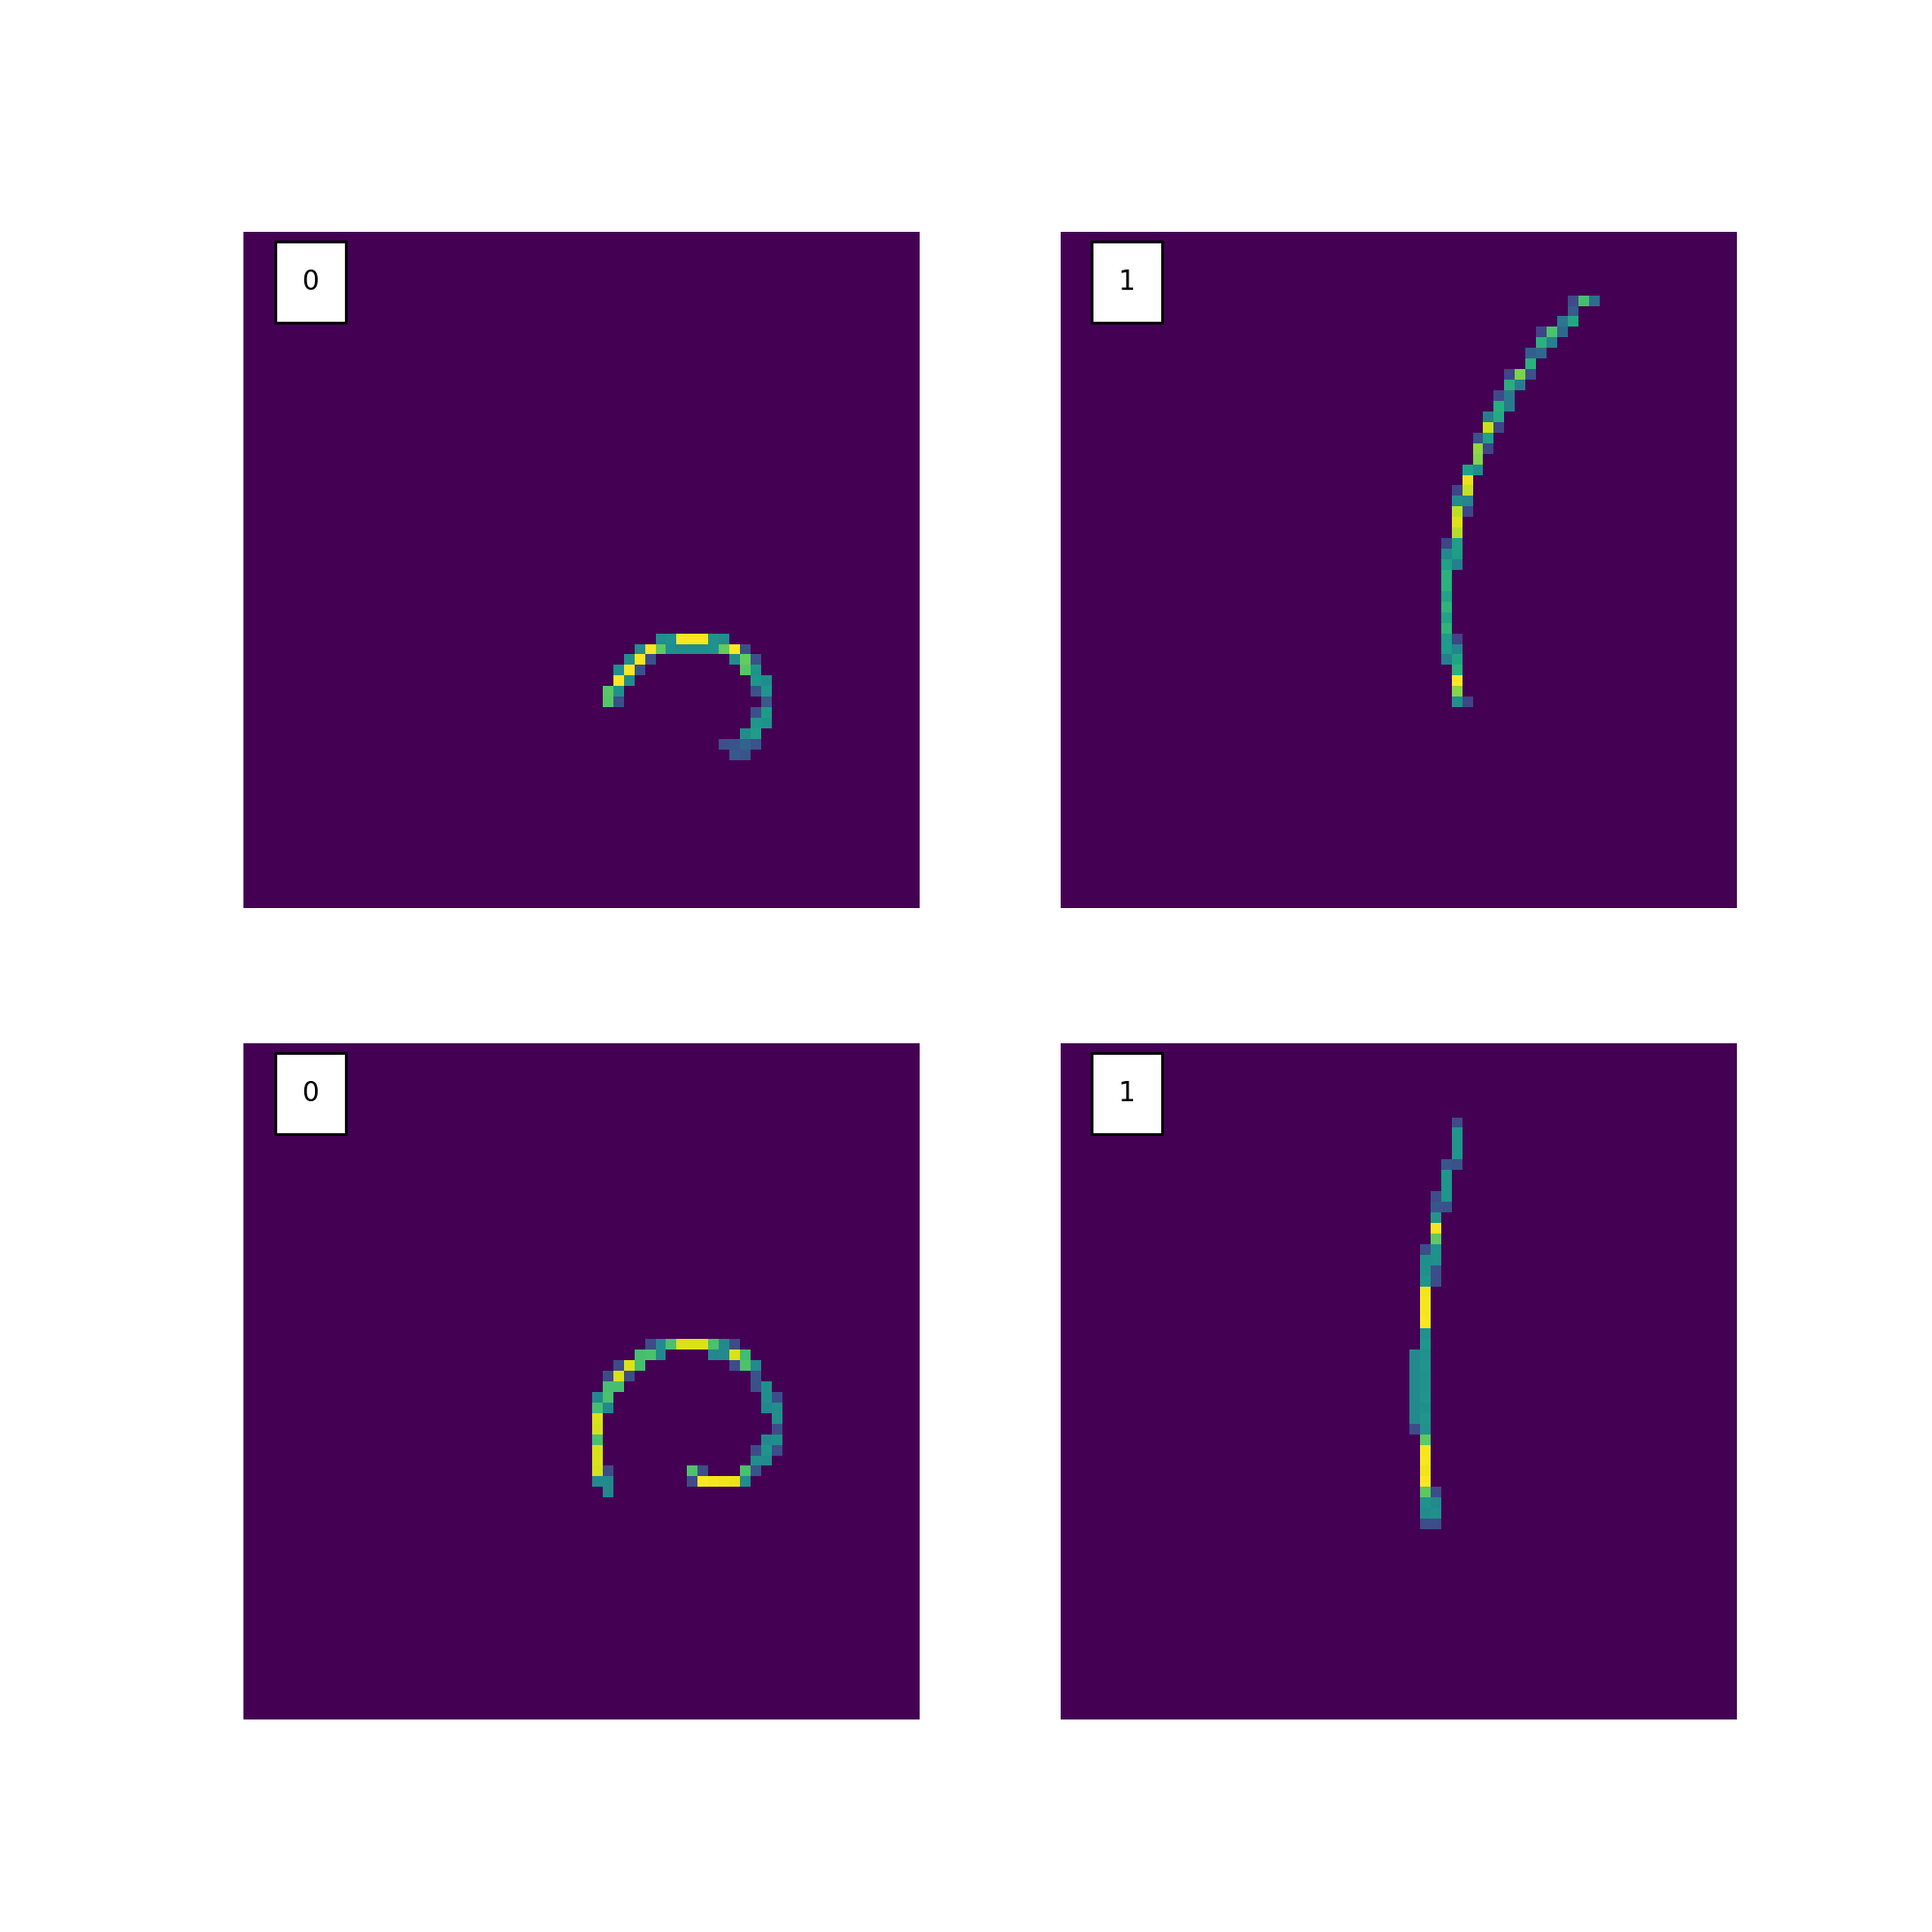

In [48]:
import matplotlib.pyplot as plt

rows = 2
cols = 2
n_plots = rows*cols
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10 ))


for row in axs: 
    for ax in row:
        """
        one of pythons most wonderful attributes is that if an object is iterable it can be
        directly iterated over, like above. 
        ax is an axis object from the 2d array of axis objects
        """

        which = np.random.randint(0, train_X.shape[0])
        ax.imshow(train_X[which].reshape(64, 64))
        ax.text(5, 5, "{}".format(int(train_y[which])), bbox={'facecolor': 'white', 'pad': 10})
        ax.axis("off")

## 1d: Encoding the targets: 

For classification one ordinarily encodes the target as a n-element zero vector with one element valued at 1 indicating the target class. This is simply called one-hot encoding.

You should inspect the values of the target vectors and use the imported `OneHotEncoder` to convert the targets. 

Note that this is not necessary for the two class case, but we do it to demonstrate a general approach. 

In [5]:
from sklearn.preprocessing import OneHotEncoder

onehot_train_y = OneHotEncoder(sparse=False, categories="auto").fit_transform(train_y.reshape(-1, 1))
onehot_test_y = OneHotEncoder(sparse=False, categories="auto").fit_transform(test_y.reshape(-1, 1))

print("Onehot train targets:", onehot_train_y.shape)
print("Onehot test targets:",onehot_test_y.shape)

Onehot train targets: (6800, 2)
Onehot test targets: (1200, 2)


## 2a: Creating a model

In this task we will create a CNN with fully connected bottom-layers for classification. You should base your code on Morten's code for a model. We suggest you complete one of the following for this task: 

1. Implement a class or function `cnn` that returns a compiled Keras model with an arbitrary number of convolutional and fully connected layers with optional configuration of regularization terms or layers.
2. Implement a simple hard-coded function `cnn` that returns a Keras model object. The architecture should be specified in the function. 

Both implementations should include multiple convolutional layers and ending with a couple fully connected layers. The output of the network should be a softmax or log-softmax layer of logits.  

You should experiment with where in the network you place the non-linearities and whether to use striding or pooling to reduce the input. As well as the use of padding, would you need one for the first layer?  

In [36]:
model_config = {
    "n_conv":2,
    "receptive_fields":[3, 3],
    "strides":[1, 1,],
    "n_filters":[2, 2],
    "conv_activation":[1, 1],
    "max_pool":[1, 1],
    
    "n_dense":1,
    "neurons":[10,],
    "dense_activation":[1,]
    }

In [58]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, ReLU, Input, Softmax
from keras.regularizers import l2

def create_convolutional_neural_network_keras(input_shape, config, n_classes=2):
    """
    Modified from MH Jensen's course on machine learning in physics: 
    https://github.com/CompPhysics/MachineLearningMSU/blob/master/doc/pub/CNN/ipynb/CNN.ipynb
    """
    
    model=Sequential()
    
    for i in range(config["n_conv"]):
        receptive_field = config["receptive_fields"][i]
        strides = config["strides"][i]
        n_filters = config["n_filters"][i]
        pad = "same" if i == 0 else "same" 
        input_shape = input_shape if i==0 else None
        
        if i == 0:
            conv = Conv2D( 
                n_filters,
                (receptive_field, receptive_field),
                input_shape=input_shape,
                padding=pad,
                strides=strides,
                kernel_regularizer=l2(0.01)
                )
        else:
            conv = Conv2D( 
                    n_filters,
                    (receptive_field, receptive_field),
                    padding=pad,
                    strides=strides,
                    kernel_regularizer=l2(0.01)
                    )
        
        model.add(conv)
        
        pool = config["max_pool"][i]
        activation = config["conv_activation"][i]
        
        if activation:
            model.add(ReLU())
            
        if pool:
            model.add(MaxPooling2D(2))
    
    model.add(Flatten())
    
    for i in range(config["n_dense"]):
        n_neurons = config["neurons"][i]
        model.add(
            Dense(
                n_neurons,
                kernel_regularizer=l2(0.01)
            ))
        
        activation = config["dense_activation"][i]
        if activation:
            model.add(ReLU())
    
    model.add(
        Dense(
            n_classes,
            activation='softmax',
            kernel_regularizer=l2(0.01))
            )
    return model

model_o = create_convolutional_neural_network_keras(train_X.shape[1:], model_config, n_classes=2)
#model_o = mhj(train_X.shape[1:], 3, 2, 10, 2, 0.01)
print(model_o.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 64, 64, 2)         20        
_________________________________________________________________
re_lu_22 (ReLU)              (None, 64, 64, 2)         0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 32, 32, 2)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 2)         38        
_________________________________________________________________
re_lu_23 (ReLU)              (None, 32, 32, 2)         0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 2)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
__________

## 2b: Plot your model

`Keras` provides a convenient class for plotting your model architecture. You should both do this and inspect the model summary to see how many trainable parameters you have as well as to confirm that your model is reasonably put together with no dangling edges in the graph etc.

In [ ]:
from keras.utils import plot_model

plot_model(model_o, to_file="convnet.png")

![a plot of the model graph](./convnet.png)

## 2b: Compiling your model

With the constructed model ready it can now be compiled. Compiling entails unrolling the computational graph underlying the model and attaching losses at the layers you specify. For more complex models one can attach loss functions at arbitrary layers or one could define a specific loss for your particular problem.

For our case we will simply use a categorical cross-entropy, which means our network parametrizes an output of logits which we softmax to produce probabilities. In this task you should simply compile the above model with an optimizer of your choice and a categorical cross-entropy loss.

In [59]:
from keras.optimizers import SGD, adam

eta = 0.01
sgd = SGD(lr=eta, )
adam = adam(lr=eta, beta_1=0.5, )
model_o.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


## 2c: Running your model

Here you should simply use the `.fit` method of the model to train on the training set. Select a suitable subset of 
train to use as validation, this should not be the test-set. Take care to note how many trainable parameters your model has. A model with $10^5$ parameters takes about a minute per epoch to run on a 7th gen i9 intel processor. If your laptop has a nvidia GPU training should be considerably faster. 

Hint: this model is quite easy to over-fit, you should build your network with a low complexity ($10^3$ parameters), and then use hyper-parameter tuning to determine the appropriate complexity level.

The `.fit` method returns a `history` object that you can use to plot the progress of your training.

In [42]:
%matplotlib notebook 
import matplotlib.pyplot as plt
history = model_o.fit(
    x=train_X,
    y=onehot_train_y,
    batch_size=50,
    epochs=40,
    validation_split=0.15,
    verbose=2
    )

Train on 5780 samples, validate on 1020 samples
Epoch 1/40
 - 3s - loss: 0.6617 - acc: 0.6261 - val_loss: 0.6396 - val_acc: 0.6402
Epoch 2/40
 - 2s - loss: 0.6287 - acc: 0.6441 - val_loss: 0.6330 - val_acc: 0.6412
Epoch 3/40
 - 2s - loss: 0.6331 - acc: 0.6471 - val_loss: 0.6331 - val_acc: 0.6451
Epoch 4/40
 - 2s - loss: 0.6317 - acc: 0.6431 - val_loss: 0.6391 - val_acc: 0.6441
Epoch 5/40
 - 2s - loss: 0.6217 - acc: 0.6465 - val_loss: 0.6446 - val_acc: 0.6461
Epoch 6/40
 - 2s - loss: 0.6097 - acc: 0.6507 - val_loss: 0.5944 - val_acc: 0.7333
Epoch 7/40
 - 2s - loss: 0.6247 - acc: 0.6618 - val_loss: 0.6245 - val_acc: 0.7559
Epoch 8/40
 - 2s - loss: 0.6266 - acc: 0.6946 - val_loss: 0.6293 - val_acc: 0.7559
Epoch 9/40
 - 2s - loss: 0.6064 - acc: 0.7580 - val_loss: 0.5430 - val_acc: 0.8225
Epoch 10/40
 - 2s - loss: 0.5932 - acc: 0.8260 - val_loss: 0.5553 - val_acc: 0.8637
Epoch 11/40
 - 2s - loss: 0.6172 - acc: 0.7652 - val_loss: 0.5711 - val_acc: 0.8196
Epoch 12/40
 - 2s - loss: 0.5204 - ac

<IPython.core.display.Javascript object>


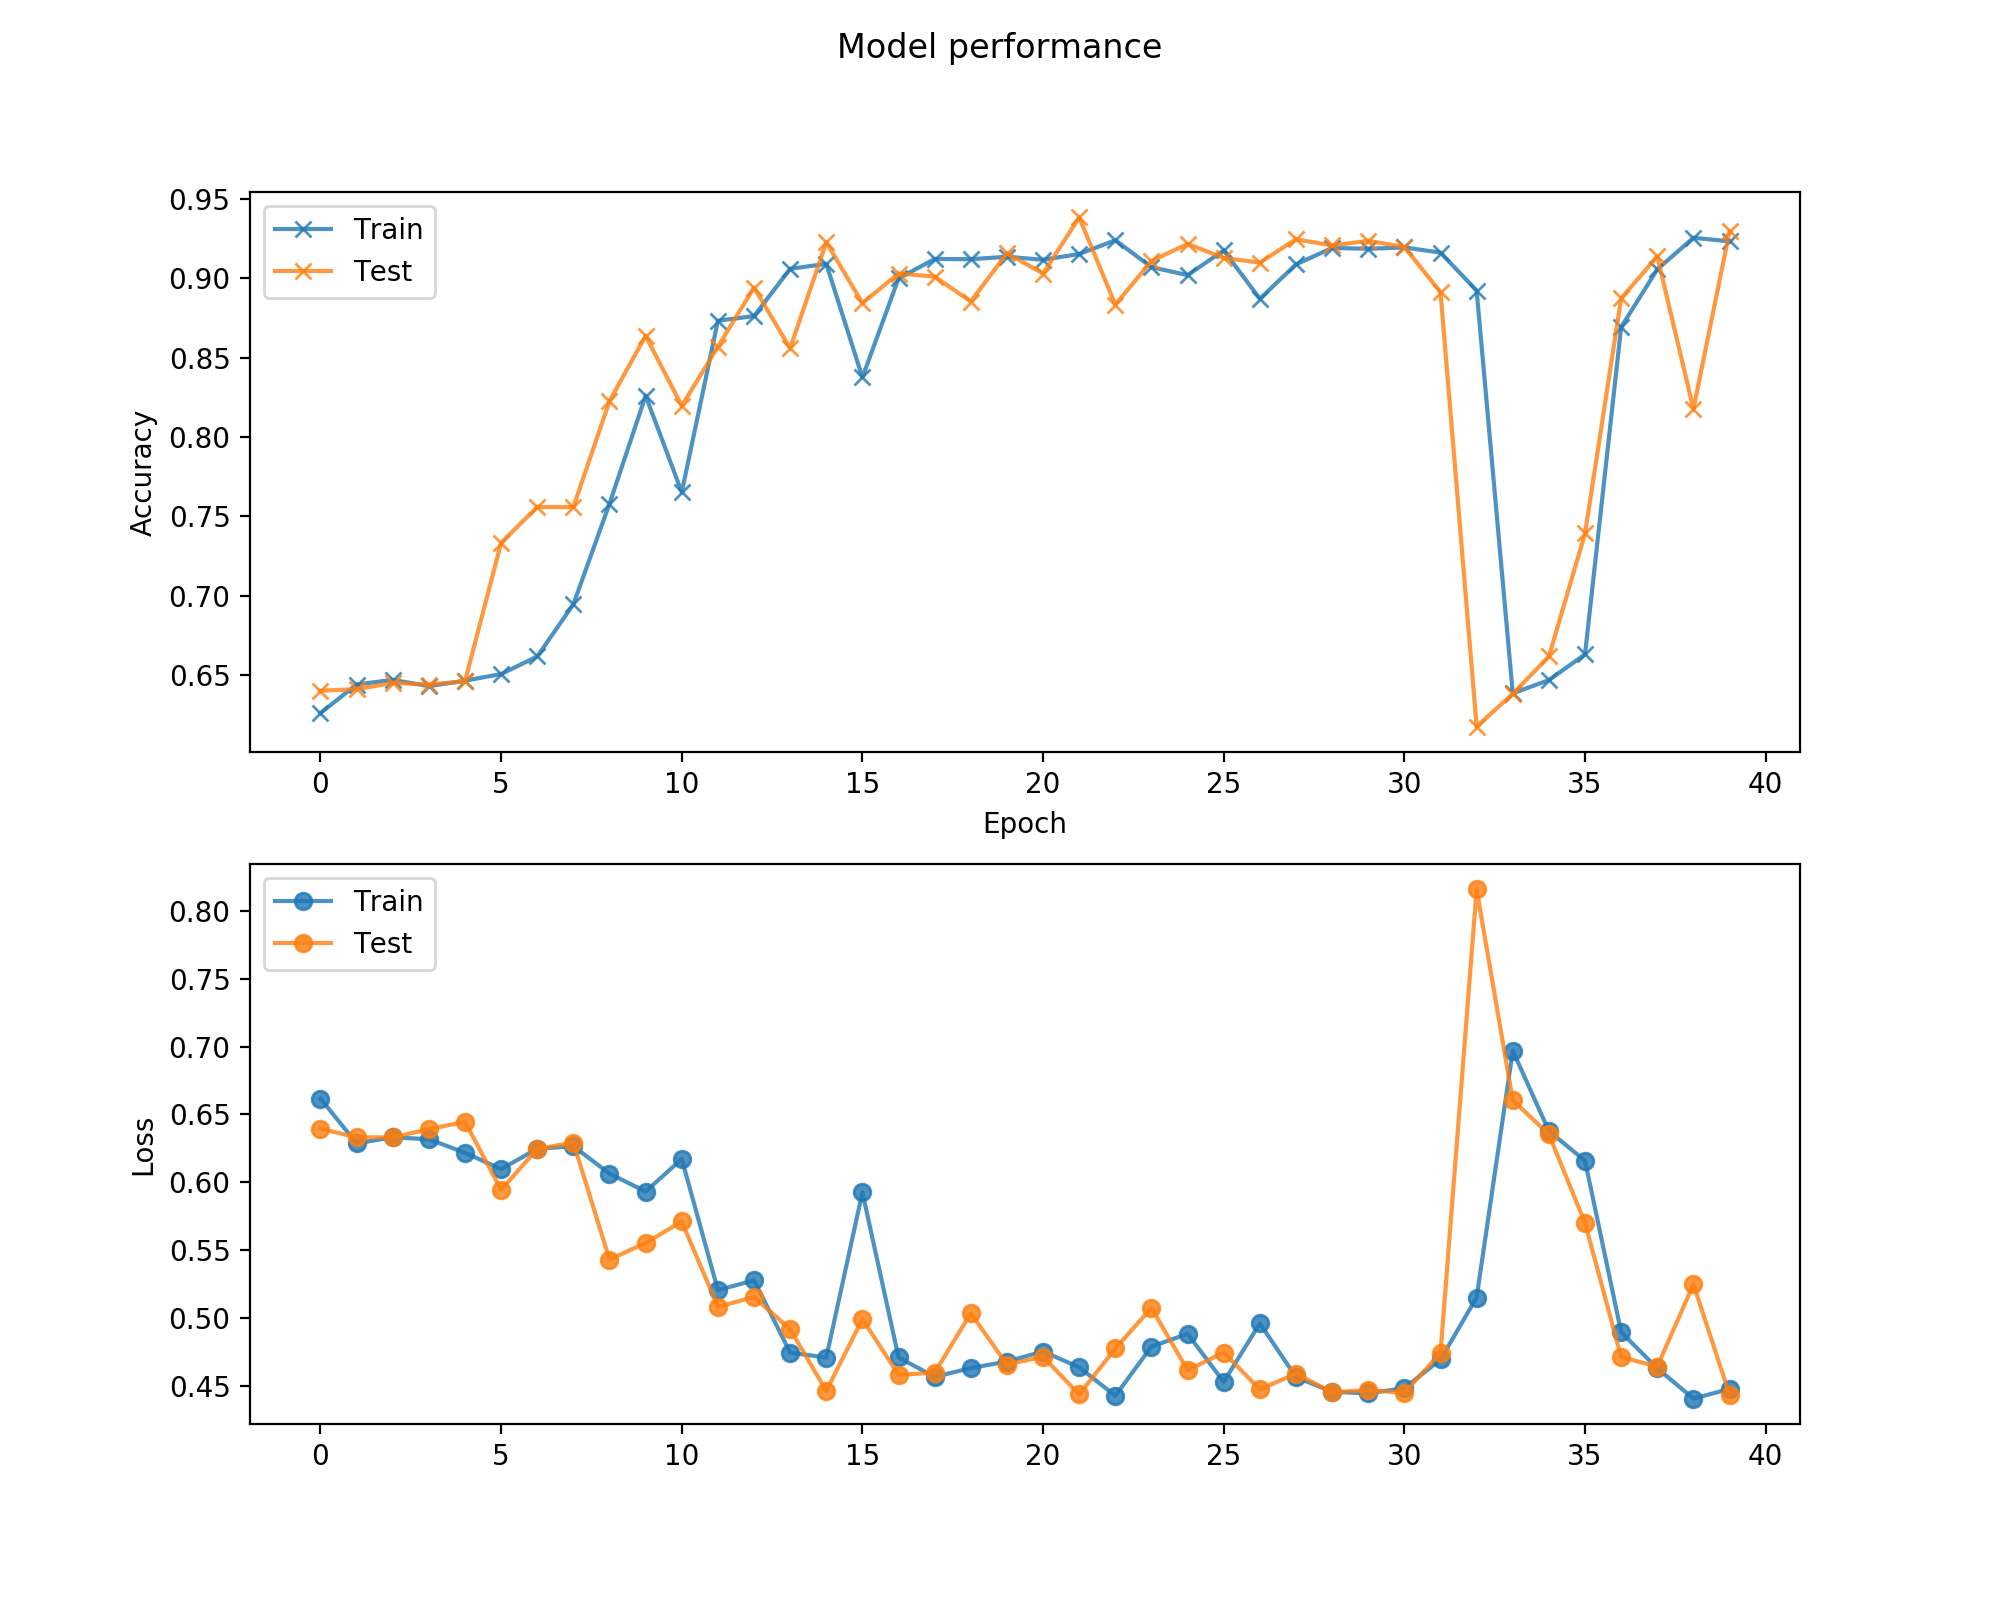

In [47]:
# copied from https://keras.io/visualization/
# Plot training & validation accuracy values
fig, axs= plt.subplots(figsize=(10, 8), nrows=2)
fig.suptitle('Model performance')
axs[0].plot(history.history['acc'], "x-",alpha=0.8)
axs[0].plot(history.history['val_acc'], "x-", alpha=0.8)

axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')


# Plot training & validation loss values

axs[1].plot(history.history['loss'], "o-",alpha=0.8)
axs[1].plot(history.history['val_loss'], "o-", alpha=0.8)

axs[1].set_ylabel('Loss')
axs[1].legend(['Train', 'Test'], loc='upper left')


## 3a: Performance validation

As mentioned in the lectures machine learning models suffer from the problem of overfitting as scaling to an almost arbitrary complexity is simple with todays hardware. The challenge then is often that of finding the correct architecture and type of model suitable for your problem. In this task you will be familiarized with some tools to monitor and estimate the degree of overfitting.

In task 1c you separated your data in training and test sets. The test set is used to estimate generalization performance. Typically we use this to fine-tune the hyperparameters. Another trick is to use a validation set during training, which we implemented in the last task for the training. 

In this task we will start with attaching callbacks to the fitting process. They are listed in the documentation for `Keras`here: https://keras.io/callbacks/
Pick ones you think are suitable for our problem and re-run the training from above.

In [61]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(min_delta=0.0001, patience=4), ModelCheckpoint("../checkpoints/ckpt")]


history = model_o.fit(
    x=train_X,
    y=onehot_train_y,
    batch_size=50,
    epochs=150,
    validation_split=0.15,
    verbose=2,
    callbacks=callbacks
    )

Train on 5780 samples, validate on 1020 samples
Epoch 1/150
 - 2s - loss: 0.5730 - acc: 0.8711 - val_loss: 0.5128 - val_acc: 0.9225
Epoch 2/150
 - 2s - loss: 0.4904 - acc: 0.9152 - val_loss: 0.5040 - val_acc: 0.9284
Epoch 3/150
 - 2s - loss: 0.4991 - acc: 0.9111 - val_loss: 0.5140 - val_acc: 0.9049
Epoch 4/150
 - 2s - loss: 0.5416 - acc: 0.8962 - val_loss: 0.5022 - val_acc: 0.9275
Epoch 5/150
 - 2s - loss: 0.4892 - acc: 0.9175 - val_loss: 0.4816 - val_acc: 0.9176
Epoch 6/150
 - 2s - loss: 0.6114 - acc: 0.8517 - val_loss: 0.6661 - val_acc: 0.8892
Epoch 7/150
 - 2s - loss: 0.5215 - acc: 0.9043 - val_loss: 0.4956 - val_acc: 0.9167
Epoch 8/150
 - 2s - loss: 0.5122 - acc: 0.9000 - val_loss: 1.1760 - val_acc: 0.5578
Epoch 9/150
 - 2s - loss: 0.6051 - acc: 0.8628 - val_loss: 0.4850 - val_acc: 0.9333


## 3b: Hyperparameter tuning

Hyperparameters, like the number of layers, learning rate or others can have a very big impact on the model quality. The model performance should also be statistically quantified using cross validation, bootstrapped confidence intervals for your performance metrics or other tools depending on model. 
In this task you should then implement a function or for loop doing either random search or a grid search over parameters and finally you should plot those results in a suitable way.